In [57]:
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [58]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku.replace("/", "").replace("  ", " ") + "." for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

def load_tsv_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    # take the fist column
    words = [line.split('\t')[1][:-1] for line in words]
    words = preprocessing(words)
    return words

def load_poems(path):
    with open(path, 'r') as f:
        poems = f.read().strip().split("\n\n")  # Split poems by double newlines
    
    all_sentences = []
    
    for poem in poems:
        sentences = poem.split("\n")
        sentences = [sentence for sentence in sentences if len(sentence) > 0]
        sentences = [sentence[:-1] if sentence[-1] in [".", ",", "!", "?"] else sentence for sentence in sentences]
        all_sentences.extend(sentences)

    all_sentences = preprocessing(all_sentences)
    return all_sentences


words = load_tsv_data('../data/dev.tsv') + load_tsv_data('../data/test.tsv') + load_tsv_data('../data/train.tsv') + load_data('../data/lines.txt') + load_poems('../data/poems.txt')
chars = sorted(list(set(''.join(words))))
special_tokens = ["<PAD>", "<BOS>", "<EOS>"]
chars = special_tokens + chars  # prepend special tokens
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [59]:
class CharDataset(torch.utils.data.Dataset):
    def __init__(self, words, chars, max_length):
        self.words = words
        self.chars = chars
        self.stoi = {ch: i for i, ch in enumerate(chars)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.max_length = max_length

    def __len__(self):
        return len(self.words)

    def encode(self, s):
        return [self.stoi[c] for c in s]

    def decode(self, tokens):
        return ''.join([self.itos[t] for t in tokens])

    def __getitem__(self, idx):
        word = self.words[idx]

        # split each string into half: src = first half, tgt = second half
        mid = max(1, len(word) // 2)
        src_str = word[:mid]
        tgt_str = word[mid:]

        # add <BOS>, <EOS>
        src = [self.stoi[c] for c in src_str]
        tgt = [self.stoi["<BOS>"]] + [self.stoi[c] for c in tgt_str] + [self.stoi["<EOS>"]]

        # pad
        src = src[:self.max_length] + [self.stoi["<PAD>"]] * (self.max_length - len(src))
        tgt = tgt[:self.max_length] + [self.stoi["<PAD>"]] * (self.max_length - len(tgt))

        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

    def get_vocab_size(self):
        return len(self.chars)

    def get_block_size(self):
        return self.max_length
    
    def contains(self, word):
        return word in self.words
    

In [60]:

class LSTMCellEfficient(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.n_embd2
        self.weight = nn.Linear(config.n_embd + config.n_embd2, 4 * config.n_embd2)
        self.dropout = nn.Dropout(p=0.2)  # Adding dropout
        self.layer_norm = nn.LayerNorm(config.n_embd2)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, xt, stm, ltm):
        if stm is None:
            stm = torch.zeros(xt.size(0), self.hidden_size, device=xt.device)
        if ltm is None:
            ltm = torch.zeros(xt.size(0), self.hidden_size, device=xt.device)

        combined = torch.cat((xt, stm), dim=-1)
        gates = self.weight(combined)
        f_gate, i_gate, o_gate, g_gate = gates.chunk(4, dim=-1)

        f_gate = torch.sigmoid(f_gate)
        i_gate = torch.sigmoid(i_gate)
        o_gate = torch.sigmoid(o_gate)
        g_gate = torch.tanh(g_gate)

        ltm = f_gate * ltm + i_gate * g_gate
        stm = o_gate * torch.tanh(ltm)

        stm = self.layer_norm(stm)
        stm = self.dropout(stm)

        return stm, ltm

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = LSTMCellEfficient(config)

    def forward(self, idx):
        b, t = idx.size()
        emb = self.wte(idx)

        stm, ltm = None, None
        for i in range(t):
            xt = emb[:, i, :]
            stm, ltm = self.cell(xt, stm, ltm)

        # Return final hidden states (context)
        return stm, ltm


class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = LSTMCellEfficient(config)
        self.out = nn.Linear(config.n_embd2, config.vocab_size)

    def forward(self, idx, stm, ltm, targets=None):
        b, t = idx.size()
        emb = self.wte(idx)

        hiddens = []
        for i in range(t):
            xt = emb[:, i, :]
            stm, ltm = self.cell(xt, stm, ltm)
            hiddens.append(stm)

        hidden = torch.stack(hiddens, 1)
        logits = self.out(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1),
                ignore_index=-1
            )
            
        return logits, loss, stm, ltm


class PoemGenerator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, src, tgt=None):
        stm, ltm = self.encoder(src)

        # Decode target (poem tokens)
        logits, loss, stm, ltm = self.decoder(tgt[:, :-1], stm, ltm, targets=tgt[:, 1:]) if tgt is not None else (None, None, stm, ltm)
        return logits, loss

    @torch.no_grad()
    def generate(self, src, max_new_tokens=50, bos_token_id=1):
        stm, ltm = self.encoder(src)

        # start with <BOS>
        idx = torch.tensor([[bos_token_id]], device=src.device)
        generated = [bos_token_id]

        for _ in range(max_new_tokens):
            logits, _, stm, ltm = self.decoder(idx, stm, ltm)
            next_token = torch.argmax(logits[:, -1, :], dim=-1)
            generated.append(next_token.item())
            idx = torch.cat([idx, next_token.unsqueeze(0)], dim=1)

            if next_token.item() == stoi["."]:
                break

        return generated

    @torch.no_grad()
    def generate_topk(self, src, max_new_tokens=50, bos_token_id=1, k=5, temperature=1.0):
        """Top-k sampling generation.

        Args:
            src: LongTensor of shape (1, T_src) with source indices.
            max_new_tokens: Max number of new tokens to sample.
            bos_token_id: Token id for <BOS> to start decoding.
            k: Top-k size.
            temperature: Softmax temperature; >1.0 = more random, <1.0 = more peaked.
        Returns:
            List[int]: generated token ids including the initial BOS and up to EOS.
        """
        stm, ltm = self.encoder(src)

        idx = torch.tensor([[bos_token_id]], device=src.device)
        generated = [bos_token_id]

        for _ in range(max_new_tokens):
            logits, _, stm, ltm = self.decoder(idx, stm, ltm)
            logits = logits[:, -1, :] / max(temperature, 1e-6)

            topk = min(k, logits.size(-1))
            topk_logits, topk_indices = torch.topk(logits, topk, dim=-1)
            probs = F.softmax(topk_logits, dim=-1)

            next_token_rel = torch.multinomial(probs, num_samples=1)  # index within top-k
            next_token = topk_indices.gather(-1, next_token_rel)      # map back to full vocab id

            token_id = next_token.item()
            generated.append(token_id)
            idx = torch.cat([idx, next_token], dim=1)

            if token_id == stoi["<EOS>"]:
                break

        return generated

In [61]:
def create_datasets(words, chars):
    # words = open(input_file, 'r').read().splitlines()
    # words = preprocessing(words)
    # words = [w.replace("/", "").replace("$", "").replace("  ", " ").strip() for w in words] 
    # words = [w for w in words if w]
    # chars = sorted(list(set(''.join(words))))
    max_word_length = max(len(w) for w in words)
    
    test_set_size = min(1000, int(len(words) * 0.1))
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset

def train_enc_dec(model, batch_loader, epochs=50000, learning_rate=0.01):
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=0.01, 
        betas=(0.9, 0.99), 
        eps=1e-8
    )

    all_losses, all_iters = [], []
    model.train()

    for epoch in range(epochs):
        X, Y = batch_loader.next()

        logits, loss = model(X, Y)

        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters


In [62]:
class InfiniteDataLoader:
    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

@dataclass
class ModelConfig:
    block_size: int = None
    vocab_size: int = None
    n_embd: int = 64
    n_embd2: int = 64

train_dataset, test_dataset = create_datasets(words, chars)
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_block_size()
config = ModelConfig(vocab_size=vocab_size, block_size=block_size)

split up the dataset into 13153 training examples and 1000 test examples


In [63]:
print(f"vocab size: {vocab_size}")
print(f"block size: {block_size}")

batch_loader = InfiniteDataLoader(train_dataset, batch_size=128)
model = PoemGenerator(config)

all_losses, all_iters = train_enc_dec(model, batch_loader, epochs=500)

vocab size: 77
block size: 120
step 0 | loss 4.2499
step 100 | loss 0.5693
step 200 | loss 0.5441
step 300 | loss 0.5081
step 400 | loss 0.5115


/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyw

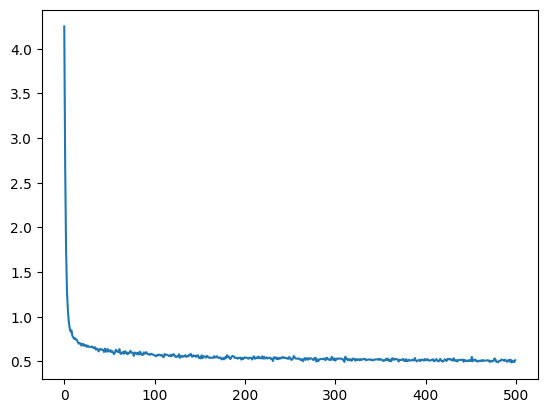

In [64]:
import matplotlib.pyplot as plt
plt.plot(all_iters, all_losses)

In [65]:
torch.save(model, "./model.pt")

In [66]:
model = torch.load('model.pt')

In [81]:
def print_samples(num=10):
    """Generate samples using the encoder-decoder model."""
    train_samples, test_samples, new_samples = [], [], []
    for i in range(num):
        random_idx = torch.randint(0, len(train_dataset), (1,)).item()
        src, tgt = train_dataset[random_idx]
        src_tensor = src.unsqueeze(0)  # Add batch dimension
        
        try:
            generated_tokens = model.generate_topk(src_tensor, max_new_tokens=700, k=3, temperature=0.882)
            if len(generated_tokens) > 1:
                generated_text = train_dataset.decode(generated_tokens[1:])  # Skip BOS token
            else:
                generated_text = ""
            
            src_text = train_dataset.decode([t for t in src.tolist() if t != stoi["<PAD>"]])
            full_text = src_text + generated_text
            full_text = full_text.replace(train_dataset.itos[stoi["<EOS>"]], "")
            
            if train_dataset.contains(full_text):
                train_samples.append(full_text)
            elif test_dataset.contains(full_text):
                test_samples.append(full_text)
            else:
                new_samples.append(full_text)
                
        except Exception as e:
            print(f"Error generating sample {i}: {e}")
            continue
    
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            cleaned_word = word.replace("/", "").replace("$", "").replace("  ", " ").replace(" .", ".")
            print(cleaned_word)
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
the rafters buckle and the embers brare waten.
sun streams through glass panes gold warmthn want.
from his own tripode will.
i invented you no flaws only peres its.
my phone reflected t we set.
as summer ends the shades project ted are.
his balls were dangling like the et we warmy.
drowning in dharma a raft making i the way.
grievance good given a higher posede sounds.
the past may tempt you to dwell in an in sead.
--------------------------------------------------------------------------------
